## How to do it...

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
np.random.seed(seed=1)
tf.random.set_seed(seed=1)
random.seed(1)

In [2]:
batch_size = 50

In [3]:
def print_board(board):
    symbols=['O', ' ', 'X']
    board_plus1 = [int(x) + 1 for x in board]
    board_line1 = '{} | {} | {}'.format(symbols[board_plus1[0]],
                                        symbols[board_plus1[1]],
                                        symbols[board_plus1[2]])
    board_line2 = '{} | {} | {}'.format(symbols[board_plus1[3]],
                                        symbols[board_plus1[4]],
                                        symbols[board_plus1[5]])
    board_line3 = '{} | {} | {}'.format(symbols[board_plus1[6]],
                                        symbols[board_plus1[7]],
                                        symbols[board_plus1[8]])
    print(board_line1)
    print('___________')
    print(board_line2)
    print('___________')
    print(board_line3)

In [4]:
def get_symmetry(board, response, transformation):
    '''
    :param board: list of integers 9 long:
    opposing mark = -1
    friendly mark = 1
    empty space = 0
    :param transformation: one of five transformations on a board:
    rotate180, rotate90, rotate270, flip_v, flip_h
    :return: tuple: (new_board, new_response)'''
    
    if transformation == 'rotate180':
        new_response = 8 - response
        return board[::-1], new_response
    
    elif transformation == 'rotate90':
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return [value for item in tuple_board for value in item], new_response
    
    elif transformation == 'rotate270':
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return [value for item in tuple_board for value in item], new_response
    
    elif transformation == 'flip_v':
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(response)
        return board[6:9] + board[3:6] + board[0:3], new_response
    
    elif transformation == 'flip_h':
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(response)
        new_board = board[::-1]
        return new_board[6:9] + new_board[3:6] + new_board[0:3], new_response
    
    else:
        raise ValueError('Method not implemented.')

In [5]:
def get_moves_from_csv(csv_file):
    '''
    :param csv_file: csv file location containing the boards w/ responses
    :return: moves: list of moves with index of best response    
    '''
    moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            moves.append(([int(x) for x in row[0:9]], int(row[9])))
    return moves

In [6]:
def get_rand_move(moves, rand_transforms=2):
    # This function performs random transformations on a board.
    (board, response) = random.choice(moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for i in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, response) = get_symmetry(board, response, random_transform)
    return board, response

In [7]:
moves = get_moves_from_csv('base_tic_tac_toe_moves.csv')
# Create a train set:
train_length = 500
train_set = []
for t in range(train_length):
    train_set.append(get_rand_move(moves))

In [8]:
test_board = [-1, 0, 0, 1, -1, -1, 0, 0, 1]
train_set = [x for x in train_set if x[0] != test_board]

In [9]:
def init_weights(shape):
    return tf.Variable(tf.random.normal(shape))

A1 = init_weights([9, 81])
bias1 = init_weights([81])
A2 = init_weights([81, 9])
bias2 = init_weights([9])

In [10]:
# Initialize input data
X = tf.keras.Input(dtype=tf.float32, batch_input_shape=[None, 9])
hidden_output = tf.keras.layers.Lambda(lambda x: tf.nn.sigmoid(tf.add(tf.matmul(x, A1), bias1)))(X)
final_output = tf.keras.layers.Lambda(lambda x: tf.add(tf.matmul(x, A2), bias2))(hidden_output)
model = tf.keras.Model(inputs=X, outputs=final_output, name='tic_tac_toe_neural_network')

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(9, 81) dtype=float32>
  <tf.Variable 'Variable:0' shape=(81,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(81, 9) dtype=float32>
  <tf.Variable 'Variable:0' shape=(9,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [11]:
optimizer = tf.keras.optimizers.SGD(0.025)

In [12]:
# Initialize variables
loss_vec = []
for i in range(10_000):
    rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
    batch_data = [train_set[i] for i in rand_indices]
    x_input = [x[0] for x in batch_data]
    y_target = np.array([y[1] for y in batch_data])
    
    # Open a GradientTape
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass.
        output = model(np.array(x_input, dtype=float))
        
        # Apply loss function(Cross entropy loss)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels=y_target))
        loss_vec.append(loss)
        
    # Get gradients of loss with reference to the weights and bias variables to adjust
    gradients_A1 = tape.gradient(loss, A1)
    gradients_b1 = tape.gradient(loss, bias1)
    gradients_A2 = tape.gradient(loss, A2)
    gradients_b2 = tape.gradient(loss, bias2)

    # Update the weights and bias variables of the model.
    optimizer.apply_gradients(zip([gradients_A1, gradients_b1, gradients_A2, gradients_b2],
                                  [A1, bias1, A2, bias2]))

    if (i) % 500 == 0:
        print(f'Iteration: {i}, Loss: {loss}')

Iteration: 0, Loss: 9.745210647583008
Iteration: 500, Loss: 1.8692318201065063
Iteration: 1000, Loss: 1.447023630142212
Iteration: 1500, Loss: 1.4928317070007324
Iteration: 2000, Loss: 1.357935905456543
Iteration: 2500, Loss: 0.956774890422821
Iteration: 3000, Loss: 1.1083436012268066
Iteration: 3500, Loss: 1.2603338956832886
Iteration: 4000, Loss: 0.8745458722114563
Iteration: 4500, Loss: 0.7953532338142395
Iteration: 5000, Loss: 0.9076696634292603
Iteration: 5500, Loss: 0.8191037774085999
Iteration: 6000, Loss: 0.8957198858261108
Iteration: 6500, Loss: 0.8624899387359619
Iteration: 7000, Loss: 0.9124799370765686
Iteration: 7500, Loss: 0.7910048961639404
Iteration: 8000, Loss: 0.8169861435890198
Iteration: 8500, Loss: 0.7862880825996399
Iteration: 9000, Loss: 0.636460542678833
Iteration: 9500, Loss: 0.7697885632514954


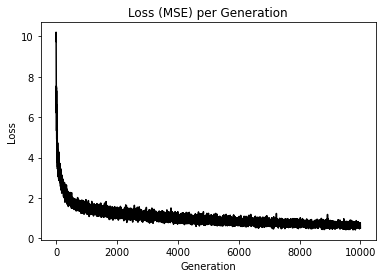

In [14]:
plt.plot(loss_vec, 'k-', label='loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [15]:
# Make Prediction:
test_boards = [test_board]
logits = model.predict(test_boards)
predictions = tf.argmax(logits, 1)
print(predictions)

tf.Tensor([2], shape=(1,), dtype=int64)


In [16]:
# Declare function to check for win
def check(board):
    wins = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]]
    for ix in range(len(wins)):
        if board[wins[ix][0]] == board[wins[ix][1]] == board[wins[ix][2]] == 1.:
            return 1
        elif board[wins[ix][0]] == board[wins[ix][1]] == board[wins[ix][2]] == -1.:
            return -1
    return 0

# Let's play against our model
game_tracker = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
win_logical = False
num_moves = 0
while not win_logical:
    player_index = input('Input index of your move (0-8): ')
    num_moves += 1
    # Add player move to game
    game_tracker[int(player_index)] = 1.
    
    # Get model's move by first getting all the logits for each index
    [potential_moves] = model(np.array([game_tracker], dtype=float))
    # Now find allowed moves (where game tracker values = 0.0)
    allowed_moves = [ix for ix, x in enumerate(game_tracker) if x == 0.0]
    # Find best move by taking argmax of logits if they are in allowed moves
    model_move = np.argmax([x if ix in allowed_moves else -999.0 for ix, x in enumerate(potential_moves)])
    
    # Add model move to game
    game_tracker[int(model_move)] = -1.
    print('Model has moved')
    print_board(game_tracker)
    # Now check for win or too many moves
    if check(game_tracker) == -1 or num_moves >= 5:
        print('Game Over!')
        win_logical = True
    elif check(game_tracker) == 1:
        print('Congratulations, You won!')
        win_logical = True

Input index of your move (0-8): 1
Model has moved
  | X | O
___________
  |   |  
___________
  |   |  
Input index of your move (0-8): 4
Model has moved
  | X | O
___________
O | X |  
___________
  |   |  
Input index of your move (0-8): 7
Model has moved
  | X | O
___________
O | X |  
___________
  | X | O
Congratulations, You won!


Not perfect, could benefit from better NN architecture or a reinforcement learning approach. 